#  Использование предобученных моделей для классификации изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://pytorch.org/vision/stable/models.html
* https://albumentations.ai/docs/getting_started/image_augmentation/

## Задачи для совместного разбора

1\. Загрузите предобученную модель из `torchvision`. Познакомьтесь с ее архитектурой. Заморозьте веса нескольких слоев.

## Задачи для самостоятельного решения

In [ ]:
!pip install torchmetrics

In [2]:
from torchvision.models import vgg16
import torchvision.models as models
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms.v2 as T
import torch as th
import torch.nn as nn
import torch.optim as optim
import torchmetrics as M

<p class="task" id="1"></p>

1\. Используя реализацию из `torchvision`, cоздайте модель `vgg16` и загрузите предобученные веса `IMAGENET1K_V1`. Выведите на экран структуру модели, количество слоев и количество настраиваемых (`requires_grad==True`) параметров модели.

- [x] Проверено на семинаре

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
model = vgg16(models.VGG16_Weights.IMAGENET1K_V1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
k_true = 0
for param in model.parameters():
  if param.requires_grad:
    k_true += th.prod(th.tensor(param.shape))

k_layers = 0
for name, modules in model.named_children():
  layers = sum([1 for _ in modules.children()])
  if layers == 0:
    k_layers += 1
  else:
    k_layers += layers
print(f'{k_layers=}, {k_true.item()=}')

k_layers=39, k_true.item()=138357544


<p class="task" id="2"></p>

2\. Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.

К обучающему датасету примените следующее преобразование: приведите картинки к размеру 256x256, затем обрежьте по центру с размером 224х224, затем переведите изображения в тензор и нормализуйте значения интенсивности пикселей (`mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`).

К тестовому датасету примените преобразование `VGG16_Weights.IMAGENET1K_V1.transforms`.

- [x] Проверено на семинаре

In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

In [6]:
# !wget 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Qa18lQGYmIWhLw'
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/данные/cat_breeds_4.zip') as zip:
  ZipFile.extractall(zip)

In [7]:
shuffled_indices = th.randperm(4000)
train_indices = shuffled_indices[:int(4000 * 0.8)]
test_indices = shuffled_indices[int(4000 * 0.8):]
train_indices.shape, test_indices.shape

(torch.Size([3200]), torch.Size([800]))

In [8]:
t_train = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
t_test = models.VGG16_Weights.IMAGENET1K_V1.transforms

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [9]:
train = DataLoader(
    ImageFolder('cat_breeds_4', transform=t_train),
    batch_size=128,
    sampler=SubsetRandomSampler(train_indices)
)
test = DataLoader(
    ImageFolder('cat_breeds_4', transform=t_test),
    batch_size=128,
    sampler=SubsetRandomSampler(test_indices)
)

<p class="task" id="3"></p>

3\. Заморозьте все веса модели из предыдущего задания. Замените последний слой `Linear` классификатора на новый слой, соответствующий задаче. После изменения последнего слоя выведите на экран количество настраиваемых (`requires_grad==True`) параметров модели. Решите задачу, используя модель с замороженными весами и изменнным последним слоем.

Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве.

- [ ] Проверено на семинаре

In [10]:
model.requires_grad_(False)
model.classifier[6] = nn.Linear(in_features=4096, out_features=4)
model.classifier[6].requires_grad_(True)

Linear(in_features=4096, out_features=4, bias=True)

In [ ]:
k_true = 0
for param in model.parameters():
  if param.requires_grad:
    k_true += th.prod(th.tensor(param.shape))
k_true

tensor(16388)

In [ ]:
n_epoch = 15
model.to(device='cuda')
lr = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss()
loss_curve = []
acc_curve_train = []
acc_curve_test = []

for epoch in range(n_epoch):
  acc_train = M.Accuracy(task="multiclass", num_classes=4)
  for X_b, y_b in train:
    out = model(X_b.to(device='cuda'))
    loss = crit(out, th.flatten(y_b.to(device='cuda')))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    acc_train.update(th.argmax(out.to(device='cpu'), dim=1), th.flatten(y_b))
  loss_curve.append(loss.item())

  # acc_test = M.Accuracy(task="multiclass", num_classes=4)
  # for X_b, y_b in test:
  #   out = model(X_b.to(device='cuda'))
  #   acc_test.update(th.argmax(out.to(device='cpu'), dim=1), th.flatten(y_b))

  acc_curve_train.append(acc_train.compute())
  # acc_curve_test.append(acc_test.compute())    acc_test={acc_test.compute():.5f}
  print(f'{epoch=} loss={loss.item():.5f} acc_train={acc_train.compute():.5f}')

epoch=0 loss=8.33382 acc_train=0.71719
epoch=1 loss=8.26637 acc_train=0.74063
epoch=2 loss=10.86055 acc_train=0.75156
epoch=3 loss=8.79603 acc_train=0.75437
epoch=4 loss=10.88883 acc_train=0.74000
epoch=5 loss=9.36416 acc_train=0.76719
epoch=6 loss=8.89703 acc_train=0.77000
epoch=7 loss=10.43466 acc_train=0.76125
epoch=8 loss=9.00045 acc_train=0.77438
epoch=9 loss=9.23420 acc_train=0.77844
epoch=10 loss=8.96860 acc_train=0.77938
epoch=11 loss=14.68425 acc_train=0.77469
epoch=12 loss=7.52293 acc_train=0.78844
epoch=13 loss=9.00188 acc_train=0.79156
epoch=14 loss=11.97202 acc_train=0.79188


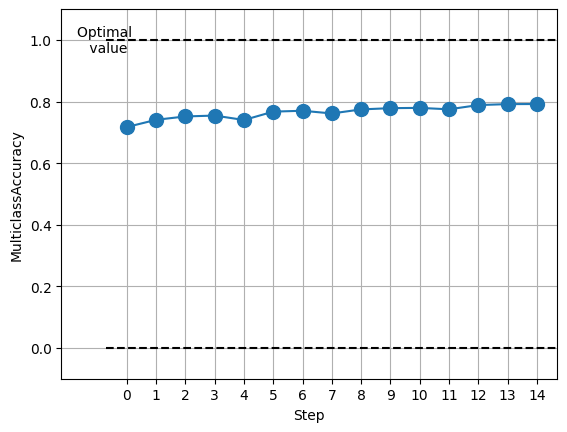

In [ ]:
acc_train.plot(acc_curve_train);

<p class="task" id="4"></p>

4\. Повторите решение предыдущей задачи, заморозив все сверточные слои, кроме последнего (слои классификатора не замораживайте). Сравните качество полученного решения и решения из предыдущей задачи, а также время, затраченное на обучения моделей.

- [ ] Проверено на семинаре

In [12]:
model.features[28].requires_grad_(True)
model.classifier.requires_grad_(True)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=4, bias=True)
)

In [13]:
%%time
n_epoch = 15
model.to(device='cuda')
lr = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss()
loss_curve = []
acc_curve_train = []
acc_curve_test = []

for epoch in range(n_epoch):
  acc_train = M.Accuracy(task="multiclass", num_classes=4)
  for X_b, y_b in train:
    out = model(X_b.to(device='cuda'))
    loss = crit(out, th.flatten(y_b.to(device='cuda')))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    acc_train.update(th.argmax(out.to(device='cpu'), dim=1), th.flatten(y_b))
  loss_curve.append(loss.item())

  # acc_test = M.Accuracy(task="multiclass", num_classes=4)
  # for X_b, y_b in test:
  #   out = model(X_b.to(device='cuda'))
  #   acc_test.update(th.argmax(out.to(device='cpu'), dim=1), th.flatten(y_b))

  acc_curve_train.append(acc_train.compute())
  # acc_curve_test.append(acc_test.compute())    acc_test={acc_test.compute():.5f}
  print(f'{epoch=} loss={loss.item():.5f} acc_train={acc_train.compute():.5f}')

epoch=0 loss=19300.66992 acc_train=0.25031
epoch=1 loss=7.56965 acc_train=0.25500
epoch=2 loss=1.37919 acc_train=0.24906
epoch=3 loss=1.38572 acc_train=0.25219
epoch=4 loss=3.54473 acc_train=0.23875
epoch=5 loss=1.38590 acc_train=0.24313
epoch=6 loss=1.43865 acc_train=0.24219
epoch=7 loss=1.38878 acc_train=0.25406
epoch=8 loss=1.38774 acc_train=0.24406
epoch=9 loss=1.38959 acc_train=0.24844
epoch=10 loss=1.38505 acc_train=0.25281
epoch=11 loss=1.38594 acc_train=0.25875
epoch=12 loss=1.38986 acc_train=0.24813
epoch=13 loss=1.38914 acc_train=0.25688
epoch=14 loss=1.38397 acc_train=0.24000
CPU times: user 7min 18s, sys: 18.5 s, total: 7min 36s
Wall time: 7min 39s


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Step', ylabel='MulticlassAccuracy'>)

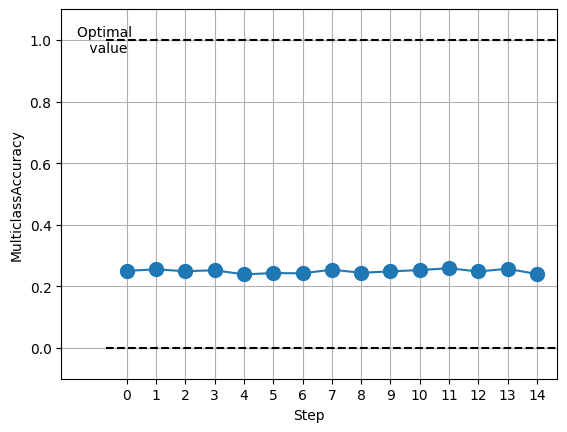

In [14]:
acc_train.plot(acc_curve_train)

<p class="task" id="5"></p>

5\. Повторите решение задачи, расширив обучающий набор данных при помощи преобразований из `torchvision`, изменяющих изображение (повороты, изменение интенсивности пикселей, обрезание и т.д.). При оценке модели на тестовой выборке данные преобразования применяться не должны. Решение о том, сколько и каких слоев модели будет обучаться, примите самостоятельно.

- [ ] Проверено на семинаре

In [16]:
t_train_new = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop((224, 224)),
    T.RandomHorizontalFlip(p=0.2),
    T.RandomVerticalFlip(p=0.2),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [17]:
train = DataLoader(
    ImageFolder('cat_breeds_4', transform=t_train_new),
    batch_size=128,
    sampler=SubsetRandomSampler(train_indices)
)
test = DataLoader(
    ImageFolder('cat_breeds_4', transform=t_test),
    batch_size=128,
    sampler=SubsetRandomSampler(test_indices)
)

In [22]:
model.requires_grad_(False)
model.classifier[6] = nn.Linear(in_features=4096, out_features=4)
model.classifier[6].requires_grad_(True)

Linear(in_features=4096, out_features=4, bias=True)

In [23]:
%%time
n_epoch = 15
model.to(device='cuda')
lr = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss()
loss_curve = []
acc_curve_train = []
acc_curve_test = []

for epoch in range(n_epoch):
  acc_train = M.Accuracy(task="multiclass", num_classes=4)
  for X_b, y_b in train:
    out = model(X_b.to(device='cuda'))
    loss = crit(out, th.flatten(y_b.to(device='cuda')))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    acc_train.update(th.argmax(out.to(device='cpu'), dim=1), th.flatten(y_b))
  loss_curve.append(loss.item())
  acc_curve_train.append(acc_train.compute())
  print(f'{epoch=} loss={loss.item():.5f} acc_train={acc_train.compute():.5f}')

epoch=0 loss=9.39764 acc_train=0.67219
epoch=1 loss=9.41172 acc_train=0.70906
epoch=2 loss=8.19165 acc_train=0.70812
epoch=3 loss=9.30267 acc_train=0.73719
epoch=4 loss=8.06697 acc_train=0.73719
epoch=5 loss=11.90550 acc_train=0.74063
epoch=6 loss=14.37996 acc_train=0.73687
epoch=7 loss=9.12870 acc_train=0.73781
epoch=8 loss=12.25246 acc_train=0.75187
epoch=9 loss=8.26112 acc_train=0.75094
epoch=10 loss=12.63610 acc_train=0.75125
epoch=11 loss=15.45846 acc_train=0.76031
epoch=12 loss=16.68418 acc_train=0.75719
epoch=13 loss=16.41614 acc_train=0.75813
epoch=14 loss=14.54836 acc_train=0.74781
CPU times: user 7min 1s, sys: 19 s, total: 7min 20s
Wall time: 7min 20s


In [26]:
import matplotlib.pyplot as plt

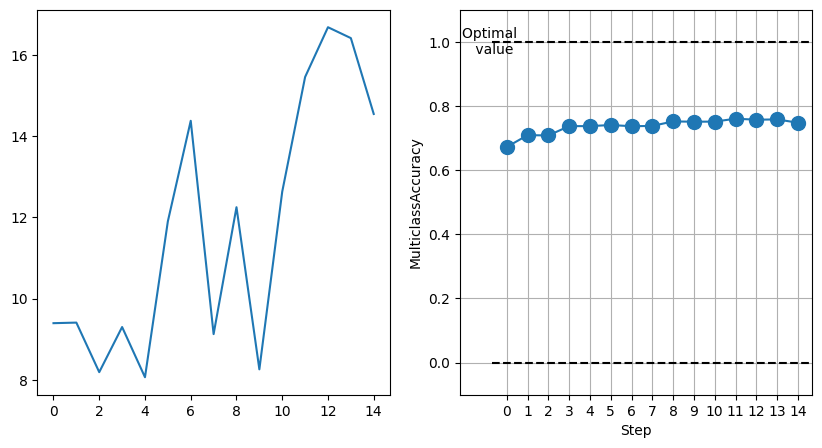

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].plot(loss_curve)
acc_train.plot(acc_curve_train, ax=ax[1])
plt.show()

## Обратная связь
- [ ] Хочу получить обратную связь по решению